In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyoway Datasheets/cleaned_data_kyoway.csv', low_memory=False)

# Drop rows with excessive missing values
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 292


In [3]:
target = 'P%_1000'

df['가탄원'] = (
    df['추가1 가탄원 장입량'] +
    df['기본 가탄원 장입량']
)

df['상급스크랩'] = (
    df['추가1 상급스크랩 장입량'] +
    df['기본 상급스크랩 장입량'] +
    df['추가2 상급스크랩 장입량']
)

df['하급스크랩'] = (
    df['추가1 하급스크랩 장입량'] +
    df['기본 하급스크랩 장입량'] +
    df['추가2 하급스크랩 장입량']
)

variables = ['가탄원', '상급스크랩', '하급스크랩',
             '출강온도', 'O%_100', '용해기 시간', '용해기 생석회 사용량', '용해기 전력사용량'
            ]
X = df[variables]
y = df[target]

# Sequential train-test split
split_index = int(len(X) * 0.7)
X_train = X.iloc[:split_index].fillna(0)
X_test = X.iloc[split_index:].fillna(0)
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [4]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, df):
    print(f"\n--- {name} Model Evaluation ---")
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    # Ensure 1-D arrays
    train_pred = np.ravel(train_pred)
    test_pred = np.ravel(test_pred)

    # Convert y to 1-D numpy arrays (handles Series/DataFrame/ndarray)
    ytr = np.ravel(np.array(y_train))
    yte = np.ravel(np.array(y_test))

    # --- Metrics ---
    mse_train = mean_squared_error(ytr, train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(ytr, train_pred)
    # Safe MAPE
    denom_tr = np.where(ytr == 0, np.finfo(float).eps, ytr)
    mape_train = np.mean(np.abs((ytr - train_pred) / denom_tr)) * 100
    r2_train = r2_score(ytr, train_pred)

    mse_test = mean_squared_error(yte, test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(yte, test_pred)
    denom_te = np.where(yte == 0, np.finfo(float).eps, yte)
    mape_test = np.mean(np.abs((yte - test_pred) / denom_te)) * 100
    r2_test = r2_score(yte, test_pred)

    # --- Print ---
    print(f"{name} Train Scores:")
    print(f"  MSE:  {mse_train:.2f}")
    print(f"  RMSE: {rmse_train:.2f}")
    print(f"  MAE:  {mae_train:.2f}")
    print(f"  MAPE: {mape_train:.2f}%")
    print(f"  R²:   {r2_train:.3f}")

    print(f"\n{name} Test Scores:")
    print(f"  MSE:  {mse_test:.2f}")
    print(f"  RMSE: {rmse_test:.2f}")
    print(f"  MAE:  {mae_test:.2f}")
    print(f"  MAPE: {mape_test:.2f}%")
    print(f"  R²:   {r2_test:.3f}")

    # --- Plots ---
    # Assumes df has a '강번' column and X indices align with df
    train_df = df[['heat_number']].loc[X_train.index].copy()
    train_df['Actual'] = ytr
    train_df['Predicted'] = train_pred
    train_df['Set'] = 'Train'

    test_df = df[['heat_number']].loc[X_test.index].copy()
    test_df['Actual'] = yte
    test_df['Predicted'] = test_pred
    test_df['Set'] = 'Test'

    combined_df = pd.concat([train_df, test_df]).sort_values('heat_number').reset_index(drop=True)
    combined_df['Time Index'] = range(len(combined_df))

    plt.figure(figsize=(16, 4))
    plt.plot(combined_df['Time Index'], combined_df['Actual'], label='Actual', linewidth=2)
    plt.plot(combined_df['Time Index'], combined_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    test_start = combined_df[combined_df['Set'] == 'Test']['Time Index'].min()
    if pd.notnull(test_start):
        plt.axvline(x=test_start, color='red', linestyle=':', label='Test Start')
    plt.xlabel('Time Index (chronological)')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target} ({name}) - R² = {r2_test:.3f}, RMSE = {rmse_test:.1f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Test-only plot
    test_df = test_df.sort_values('heat_number').reset_index(drop=True)
    test_df['Time Index'] = range(len(test_df))

    plt.figure(figsize=(18, 3))
    plt.plot(test_df['Time Index'], test_df['Actual'], label='Actual', linewidth=2)
    plt.plot(test_df['Time Index'], test_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return test_df


--- Linear Regression Model Evaluation ---
Linear Regression Train Scores:
  MSE:  4.52
  RMSE: 2.13
  MAE:  1.67
  MAPE: 6.05%
  R²:   0.031

Linear Regression Test Scores:
  MSE:  4.42
  RMSE: 2.10
  MAE:  1.70
  MAPE: 6.41%
  R²:   -0.115


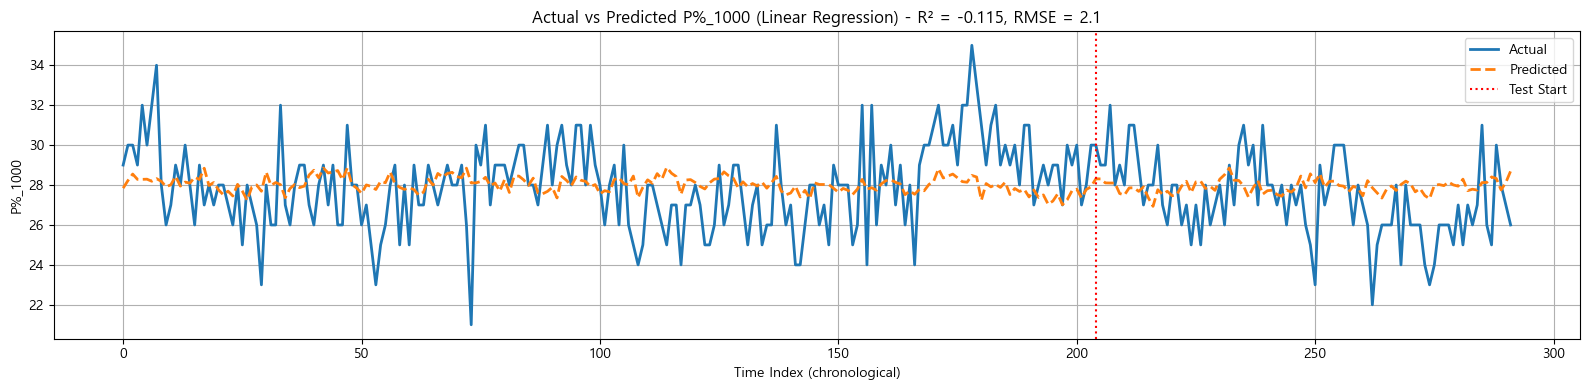

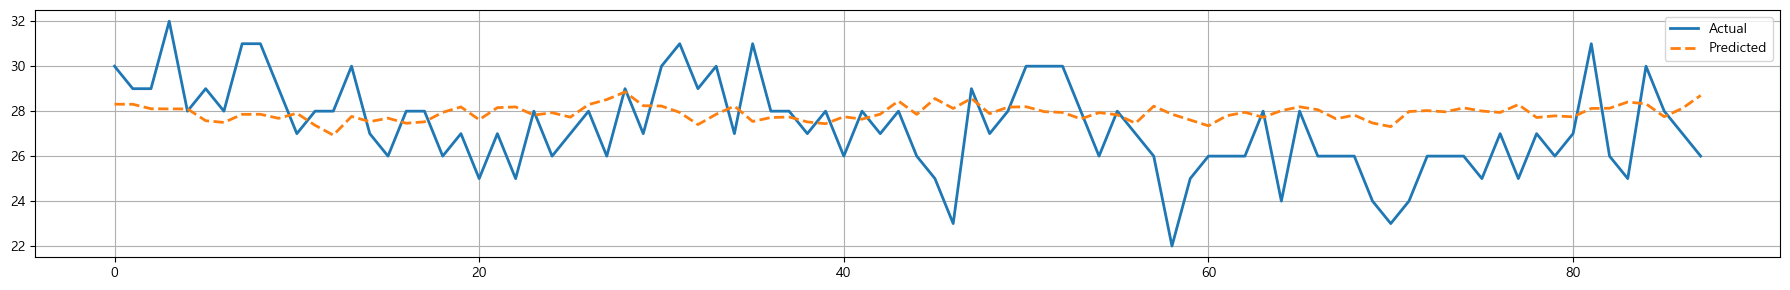

,heat_number,Actual,Predicted,Set,Time Index
0,34412,30,28.309315,Test,0
1,34413,29,28.307052,Test,1
2,34414,29,28.106887,Test,2
3,34415,32,28.100716,Test,3
4,34416,28,28.100225,Test,4
...,...,...,...,...,...
83,34495,25,28.406164,Test,83
84,34496,30,28.325459,Test,84
85,34497,28,27.753786,Test,85
86,34498,27,28.127237,Test,86


In [5]:
# --- Linear Regression ---
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
evaluate_model("Linear Regression", lin_model, X_train, y_train, X_test, y_test, df)


--- XGBoost Model Evaluation ---
XGBoost Train Scores:
  MSE:  1.15
  RMSE: 1.07
  MAE:  0.83
  MAPE: 3.01%
  R²:   0.754

XGBoost Test Scores:
  MSE:  4.57
  RMSE: 2.14
  MAE:  1.75
  MAPE: 6.53%
  R²:   -0.154


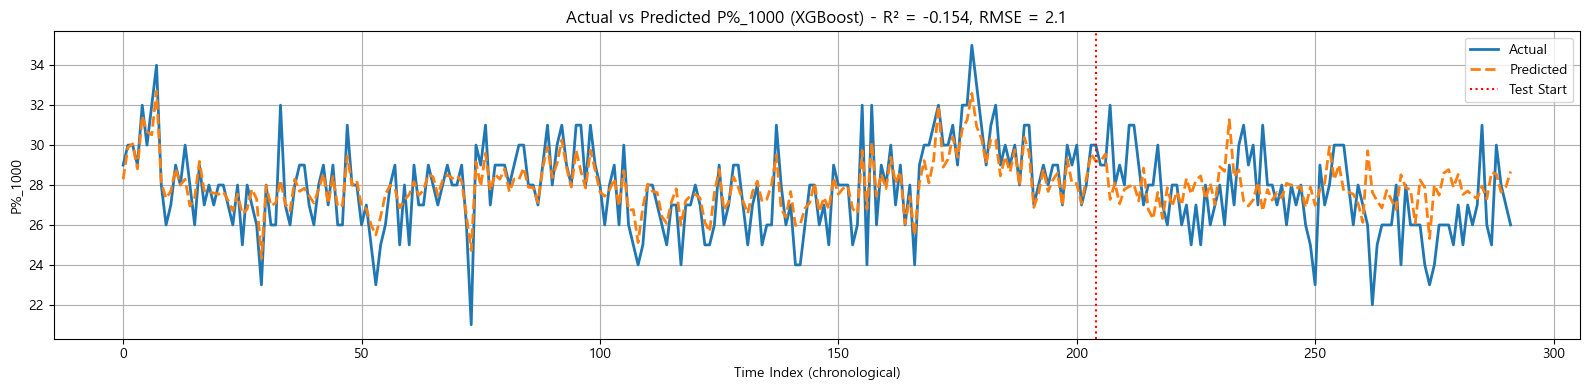

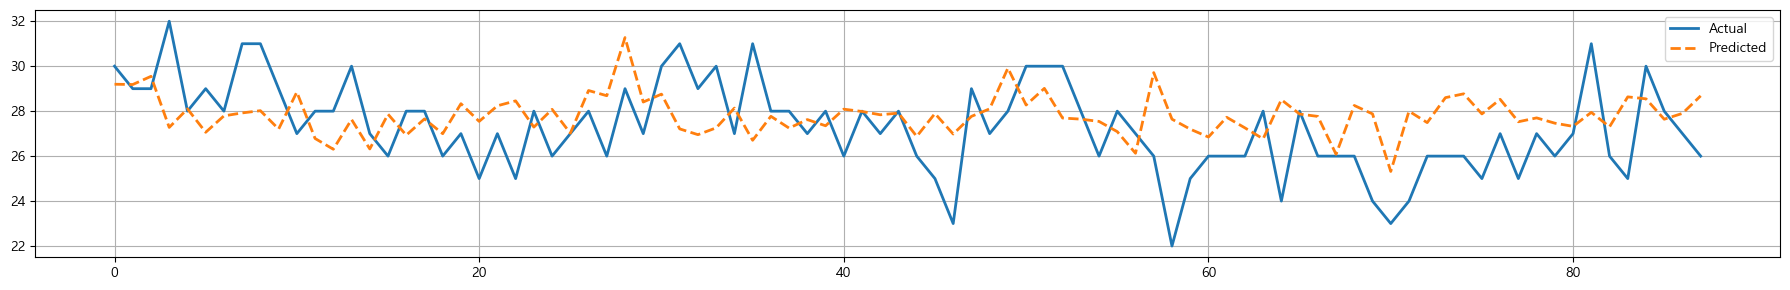

,heat_number,Actual,Predicted,Set,Time Index
0,34412,30,29.197529,Test,0
1,34413,29,29.185310,Test,1
2,34414,29,29.548674,Test,2
3,34415,32,27.277266,Test,3
4,34416,28,28.101280,Test,4
...,...,...,...,...,...
83,34495,25,28.635689,Test,83
84,34496,30,28.548702,Test,84
85,34497,28,27.640911,Test,85
86,34498,27,27.901670,Test,86


In [6]:
# --- XGBoost ---
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.005,
    max_depth=4,
    random_state=42
)
xgb_model.fit(X_train, y_train)
evaluate_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test, df)


--- Random Forest Model Evaluation ---
Random Forest Train Scores:
  MSE:  0.70
  RMSE: 0.84
  MAE:  0.65
  MAPE: 2.35%
  R²:   0.850

Random Forest Test Scores:
  MSE:  4.51
  RMSE: 2.12
  MAE:  1.68
  MAPE: 6.30%
  R²:   -0.138


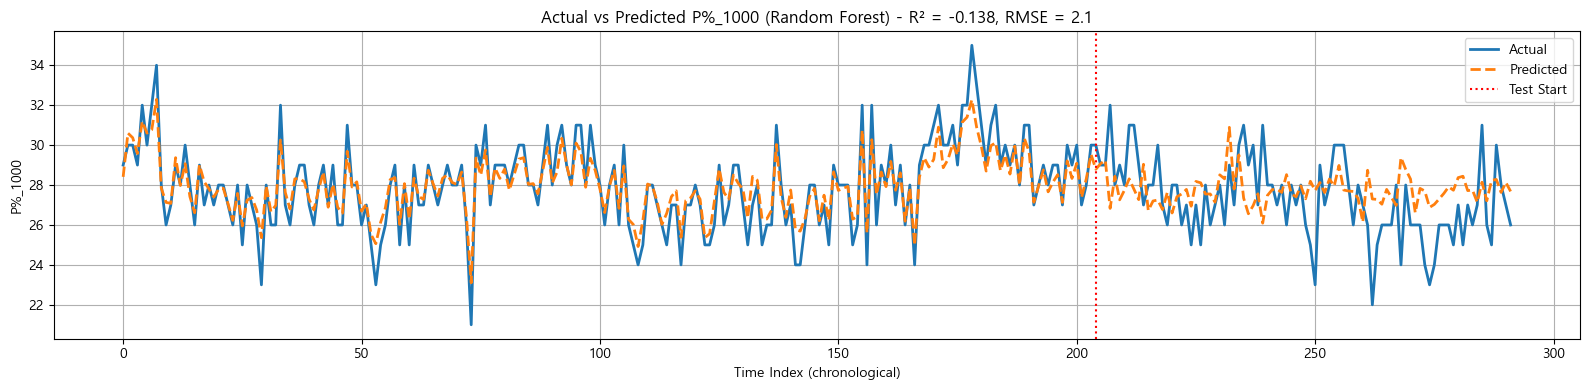

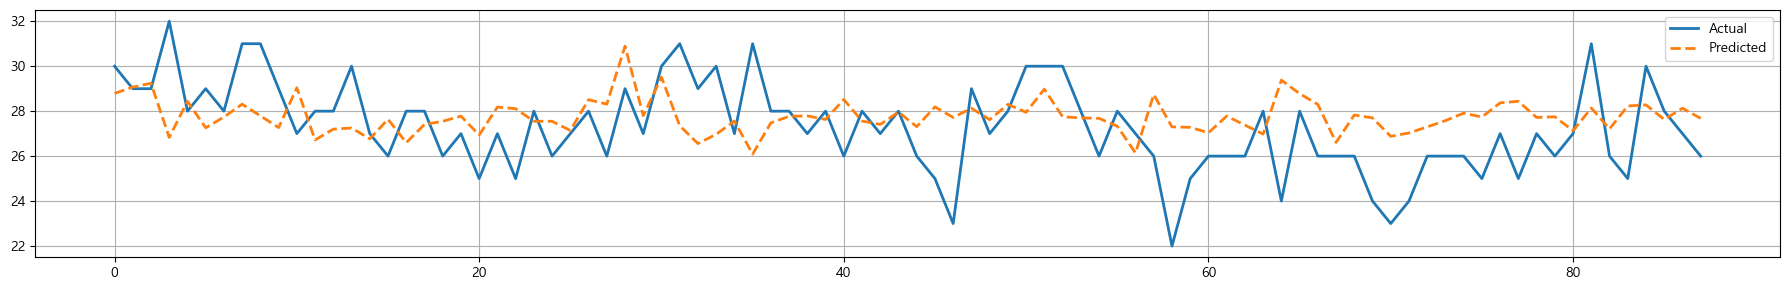

,heat_number,Actual,Predicted,Set,Time Index
0,34412,30,28.79,Test,0
1,34413,29,29.07,Test,1
2,34414,29,29.24,Test,2
3,34415,32,26.83,Test,3
4,34416,28,28.44,Test,4
...,...,...,...,...,...
83,34495,25,28.23,Test,83
84,34496,30,28.28,Test,84
85,34497,28,27.63,Test,85
86,34498,27,28.13,Test,86


In [7]:
# --- Random Forest ---
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
evaluate_model("Random Forest", rf_model, X_train, y_train, X_test, y_test, df)


--- SVR (RBF) Model Evaluation ---
SVR (RBF) Train Scores:
  MSE:  1.99
  RMSE: 1.41
  MAE:  0.84
  MAPE: 3.07%
  R²:   0.573

SVR (RBF) Test Scores:
  MSE:  5.47
  RMSE: 2.34
  MAE:  1.88
  MAPE: 7.02%
  R²:   -0.381


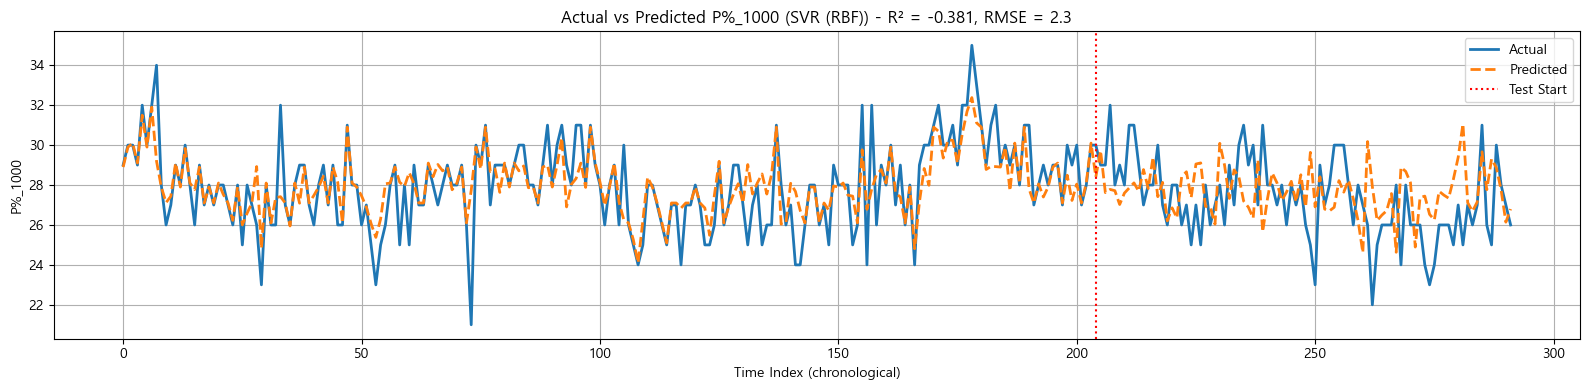

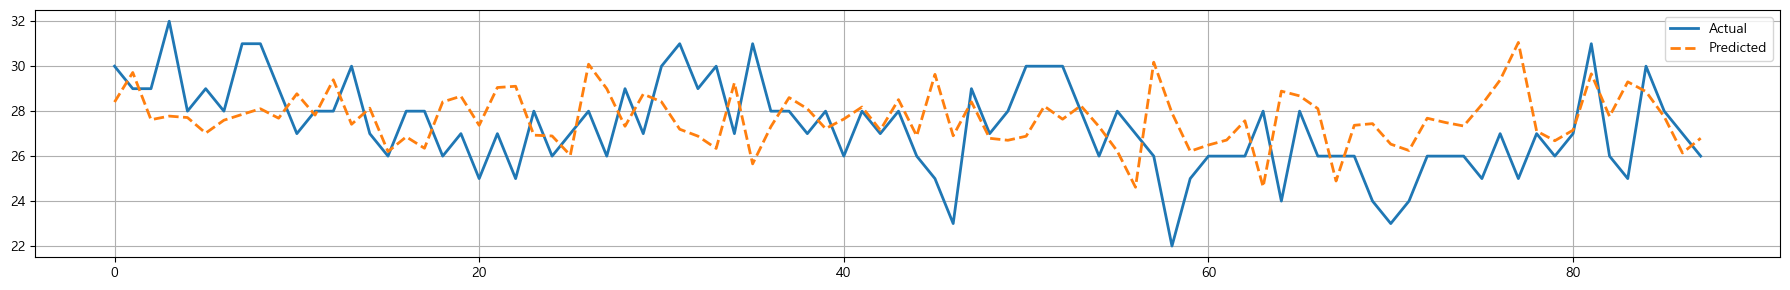

Iteration 1, loss = 389.08599024
Iteration 2, loss = 357.92390828
Iteration 3, loss = 312.95787669
Iteration 4, loss = 241.19664149
Iteration 5, loss = 138.43768295
Iteration 6, loss = 47.23870797
Iteration 7, loss = 48.96814223
Iteration 8, loss = 38.32069405
Iteration 9, loss = 24.71224748
Iteration 10, loss = 26.68608375
Iteration 11, loss = 23.75602213
Iteration 12, loss = 20.39208068
Iteration 13, loss = 19.84668141
Iteration 14, loss = 17.32173005
Iteration 15, loss = 15.51005000
Iteration 16, loss = 14.55334000
Iteration 17, loss = 13.57809133
Iteration 18, loss = 12.81523870
Iteration 19, loss = 12.16859727
Iteration 20, loss = 11.38613322
Iteration 21, loss = 10.71612732
Iteration 22, loss = 10.14276491
Iteration 23, loss = 9.54620138
Iteration 24, loss = 8.85098214
Iteration 25, loss = 8.26072710
Iteration 26, loss = 7.69237839
Iteration 27, loss = 7.26518682
Iteration 28, loss = 6.59711949
Iteration 29, loss = 6.55385134
Iteration 30, loss = 5.75792919
Iteration 31, loss = 5

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


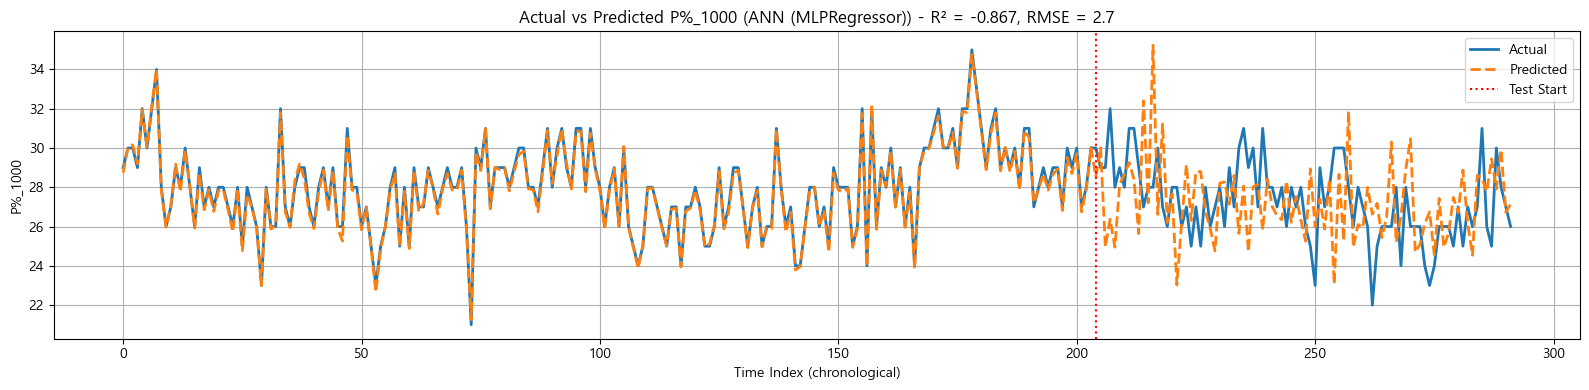

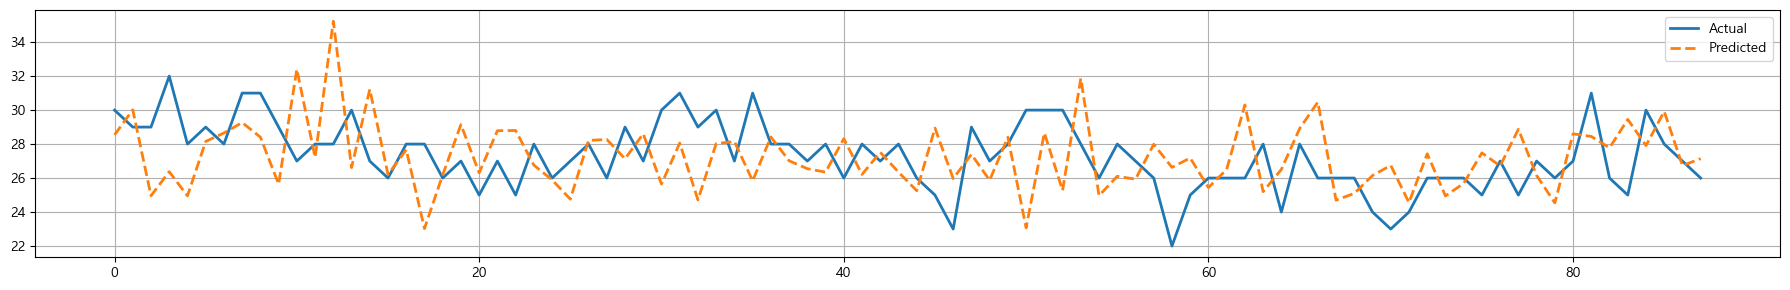

In [8]:

# === Added on 2025-08-08 04:07:56: SVM (SVR) and ANN (MLPRegressor) implementations ===
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# SVR pipeline (scale features)
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma='scale'))
])

svr_pipeline.fit(X_train, y_train)
svr_test_df = evaluate_model("SVR (RBF)", svr_pipeline, X_train, y_train, X_test, y_test, df)


ann_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(128, 128, 128, 64),
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        batch_size=50,
        max_iter=2000,
        early_stopping=False,      # don't use validation-based early stop
        n_iter_no_change=2000,     # >> max_iter so it won't stop early
        tol=0.0,                   # require strict improvement (optional)
        random_state=42,
        verbose=True
    ))
])

ann_pipeline.fit(X_train, y_train)
ann_test_df = evaluate_model("ANN (MLPRegressor)", ann_pipeline, X_train, y_train, X_test, y_test, df)

